## Visualizing Input Images and Ground Truth

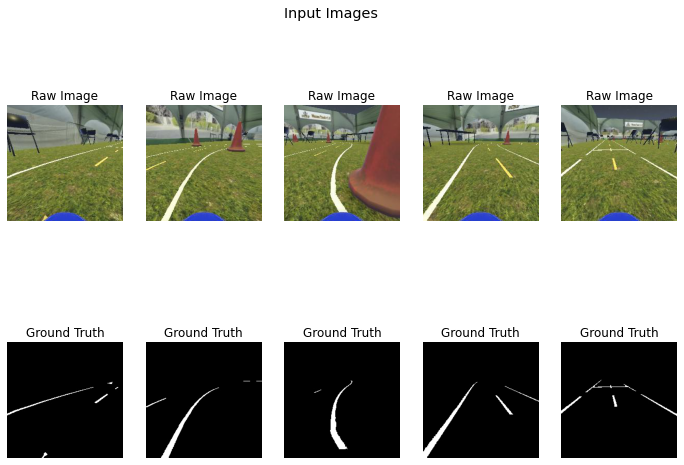

In [1]:
import matplotlib.pyplot as plt

from visualize import visualize
#visualize('./data/sim_dataset_full/train/img/','./data/sim_dataset_full_binary/',title='Input Images')
visualize('./data/224_by_224/train/img/','./data/224_224_binary/',title='Input Images')

## Build Dataloader and Set Up Device

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os

from dataset import Road_DBList

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# train_data_set = Road_DBList("./data/sim_full_train.txt")
# val_data_set = Road_DBList("./data/sim_full_val.txt")
# test_data_set = Road_DBList("./data/sim_full_test.txt")

train_data_set = Road_DBList("./data/224_train.txt")
val_data_set = Road_DBList("./data/224_val.txt")
test_data_set = Road_DBList("./data/224_test.txt")

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

batch_size = 1
test_batch_size = 1
train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=test_batch_size, shuffle=False
)

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

Training Set Size: 360
Validation Set Size: 120
Test Set Size: 40
using device: cuda


## Defining Unet Model

In [3]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.encode1 = nn.Sequential(nn.Conv2d(3,64,3,1,1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(64,64,3,1,1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        self.encode2 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(64,128,3,1,1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(128,128,3,1,1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU())
        
        self.encode3 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(128,256,3,1,1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.Conv2d(256,256,3,1,1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU())
        
        self.encode4 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(256,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU())
        
        self.encode5 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU())
        
        #self.upsample1 = nn.ConvTranspose2d(512,512,2,2)
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode1 = nn.Sequential(nn.Conv2d(1024,256,3,1,1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(256,256,3,1,1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        #self.upsample2 = nn.ConvTranspose2d(256,256,2,2)
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode2 = nn.Sequential(nn.Conv2d(512,128,3,1,1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128,128,3,1,1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        #self.upsample3 = nn.ConvTranspose2d(128,128,2,2)
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode3 = nn.Sequential(nn.Conv2d(256,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        #self.upsample4 = nn.ConvTranspose2d(64,64,2,2)
        self.upsample4 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode4 = nn.Sequential(nn.Conv2d(128,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.decode5 = nn.Conv2d(64,2,1)

    def forward(self, x):
        x = torch.unbind(x,dim=1)[-1]
        x1 = self.encode1(x)
        x2 = self.encode2(x1)
        x3 = self.encode3(x2)
        x4 = self.encode4(x3)
        x5 = self.encode5(x4)
        x = self.upsample1(x5)
        x = self.decode1(torch.cat([x4,x],dim=1))
        x = self.upsample2(x)
        x = self.decode2(torch.cat([x3,x],dim=1))
        x = self.upsample3(x)
        x = self.decode3(torch.cat([x2,x],dim=1))
        x = self.upsample4(x)
        x = self.decode4(torch.cat([x1,x],dim=1))
        x = self.decode5(x)
    
        return x


## Loading Unet Model

In [4]:
model1 = Unet()
model1.to(device)

Unet(
  (encode1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encode2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (encode3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128

## Training Unet

In [6]:
from train import Trainer
weights_pth = './Trained_Weights/unet_updated.pth'
#save_pth = './Trained_Weights/sim_full_unet/'
save_pth = './Trained_Weights/224_unet/'
epochs = 10
model1 = Trainer(
    model1,
    train_loader,
    val_loader,
    epochs,
    weights_pth,
    save_pth
)

Init Model
Validation Accuracy: 0.9775, Validation Loss: 5.428
Epochs: 0
Training Loss: 0.3803
Validation Accuracy: 0.9705, Validation Loss: 0.05137
Time Taken for Epoch:72.92545080184937 sec
Epochs: 1
Training Loss: 0.0184
Validation Accuracy: 0.9944, Validation Loss: 0.008946
Time Taken for Epoch:69.32268810272217 sec
Epochs: 2
Training Loss: 0.008554
Validation Accuracy: 0.9948, Validation Loss: 0.008464
Time Taken for Epoch:68.31338620185852 sec
Epochs: 3
Training Loss: 0.007264
Validation Accuracy: 0.9959, Validation Loss: 0.007095
Time Taken for Epoch:70.50011324882507 sec
Epochs: 4
Training Loss: 0.005372
Validation Accuracy: 0.9989, Validation Loss: 0.007006
Time Taken for Epoch:70.10850405693054 sec
Epochs: 5
Training Loss: 0.004655
Validation Accuracy: 0.9981, Validation Loss: 0.005304
Time Taken for Epoch:70.08837413787842 sec
Epochs: 6
Training Loss: 0.004263
Validation Accuracy: 0.9975, Validation Loss: 0.005478
Time Taken for Epoch:71.68881034851074 sec
Epochs: 7
Training

## Testing Unet

In [6]:
from test import test
#weights_pth = './Trained_Weights/sim_full_unet/28_0.9907.pth'
#save_pth = "./results/sim_full_unet/"
weights_pth = './Trained_Weights/224_unet/9_0.9986.pth'
save_pth = "./results/224_unet/"
test(test_loader,model1,weights_pth,save_pth)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Test Accuracy: 0.9984, Test Loss: 0.01095
Precision: 0.94, Recall: 1.0, F1_score: 0.97


(0.010953433183021843,
 0.9984105947066331,
 0.9381057682395362,
 0.9980904693226387,
 0.9669781442125334)

## Defining UnetConvLSTM Model

In [16]:
class LSTMCell(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(LSTMCell,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(input_dim+hidden_dim,4*hidden_dim,3,1,1)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self,x,c,h):
        x1 = self.conv(torch.cat([x,h],dim=1))
        i,f,o,g = x1.split(self.hidden_dim,dim=1)
        i = self.sig(i)
        f = self.sig(f)
        o = self.sig(o)
        g = self.tanh(g)

        c_new = (f*c) + (i*g)
        h_new = i * self.tanh(c_new)

        return c_new,h_new

class ConvLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,batch_size):
        super(ConvLSTM,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.cell1 = LSTMCell(self.input_dim,self.hidden_dim)
        self.cell2 = LSTMCell(self.input_dim,self.hidden_dim)

    def forward(self,x):
        x = x.transpose(0,1)
        for m in range(2):
            out_list = []
            c = torch.zeros(self.batch_size,self.hidden_dim,x.size(3),x.size(4),device=device)
            h = torch.zeros(self.batch_size,self.hidden_dim,x.size(3),x.size(4),device=device)
            for n in range(5):
                if m == 0:
                    c,h = self.cell1(x[:,n,:,:,:],c,h)
                else:
                    c,h = self.cell2(x[:,n,:,:,:],c,h)
                out_list.append(h)
            x = torch.stack(out_list,1)

        return x
    
class Unet_ConvLSTM(nn.Module):
    def __init__(self):
        super(Unet_ConvLSTM, self).__init__()
        
        self.encode1 = nn.Sequential(nn.Conv2d(3,64,3,1,1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(64,64,3,1,1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        self.encode2 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(64,128,3,1,1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(128,128,3,1,1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU())
        
        self.encode3 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(128,256,3,1,1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.Conv2d(256,256,3,1,1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU())
        
        self.encode4 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(256,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU())
        
        self.encode5 = nn.Sequential(nn.MaxPool2d(2,stride=2),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.Conv2d(512,512,3,1,1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU())
        
        #self.upsample1 = nn.ConvTranspose2d(512,512,2,2)
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode1 = nn.Sequential(nn.Conv2d(1024,256,3,1,1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(256,256,3,1,1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        #self.upsample2 = nn.ConvTranspose2d(256,256,2,2)
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode2 = nn.Sequential(nn.Conv2d(512,128,3,1,1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128,128,3,1,1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        #self.upsample3 = nn.ConvTranspose2d(128,128,2,2)
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode3 = nn.Sequential(nn.Conv2d(256,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        #self.upsample4 = nn.ConvTranspose2d(64,64,2,2)
        self.upsample4 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.decode4 = nn.Sequential(nn.Conv2d(128,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64,64,3,1,1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.decode5 = nn.Conv2d(64,2,1)
        self.convlstm = ConvLSTM(512,512,batch_size)
        
    def forward(self, x):
        x = torch.unbind(x,dim=1)
        x_list = []
        for i in x:
            x1 = self.encode1(i)
            x2 = self.encode2(x1)
            x3 = self.encode3(x2)
            x4 = self.encode4(x3)
            x5 = self.encode5(x4)
            x_list.append(x5.unsqueeze(0))
        x_list = torch.cat(x_list,0)
        x_out = self.convlstm(x_list)[:,-1,:,:,:]
        x = self.upsample1(x_out)
        x = self.decode1(torch.cat([x4,x],dim=1))
        x = self.upsample2(x)
        x = self.decode2(torch.cat([x3,x],dim=1))
        x = self.upsample3(x)
        x = self.decode3(torch.cat([x2,x],dim=1))
        x = self.upsample4(x)
        x = self.decode4(torch.cat([x1,x],dim=1))
        x = self.decode5(x)
    
        return x
    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())



## Loading UnetConvLSTM Model

In [17]:
model2 = Unet_ConvLSTM()
model2.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 9.97 GiB already allocated; 3.38 MiB free; 10.08 GiB reserved in total by PyTorch)

## Training UnetConvLSTM

In [14]:
from train import Trainer
# weights_pth = './Trained_Weights/unetlstm_updated.pth'
# save_pth = './Trained_Weights/sim_full_convlstm/'
weights_pth = './Trained_Weights/unetlstm_updated.pth'
save_pth = './Trained_Weights/224_convlstm/'
epochs = 30
model2 = Trainer(
    model2,
    train_loader,
    val_loader,
    epochs,
    weights_pth,
    save_pth
)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 9.97 GiB already allocated; 3.38 MiB free; 10.08 GiB reserved in total by PyTorch)

## Testing UnetConvLSTM

In [7]:
from test import test
weights_pth = './Trained_Weights/sim_full_convlstm/27_0.9905.pth'
save_pth = "./results/sim_full_convlstm/"
test(test_loader,model2,weights_pth,save_pth)

0
1
2


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Test Accuracy: 0.9991, Test Loss: 0.2911
Precision: 0.99, Recall: 0.98, F1_score: 0.98


(0.29113684333860873,
 0.999066162109375,
 0.9906524539672826,
 0.975142682146096,
 0.9827527671945454)

## Visualizing Results

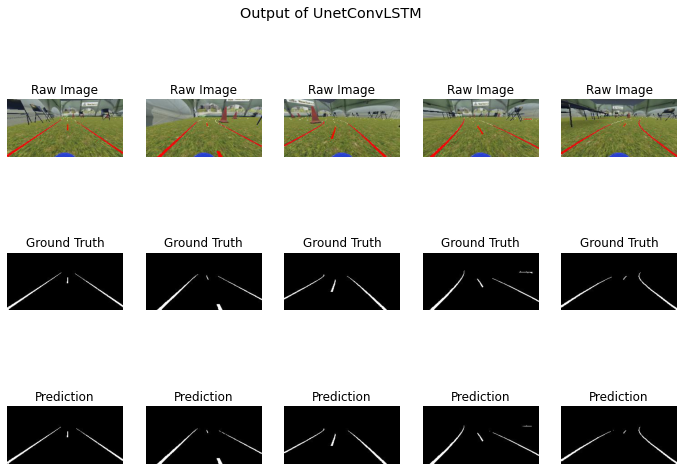

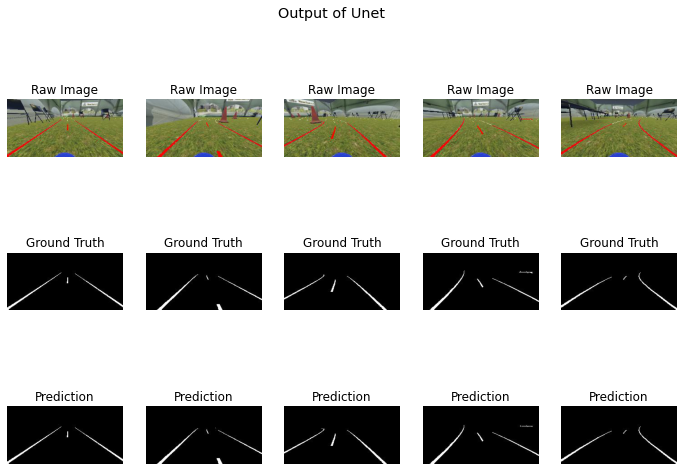

In [8]:
from visualize import visualize
visualize(result_path='./results/sim_full_convlstm/',title='Output of UnetConvLSTM')
visualize(result_path='./results/sim_full_unet/',title='Output of Unet')

## Testing on 1 Continuous Sequence

In [11]:
from test_realtime import test
print("Time taken by Unet Model for predicting 1 continuous sequence")
test_seq_path = './data/sim_dataset_full/test/img/22/22_'
weights_pth = './Trained_Weights/sim_full_unet/28_0.9907.pth'
save_pth = "./results/sim_unet_realtime/"
test(model1,test_seq_path,weights_pth,save_pth)
print("\nTime taken by UnetConvLSTM Model for predicting 1 continuous sequence")
test_seq_path = './data/sim_dataset_full/test/img/22/22_'
weights_pth = './Trained_Weights/sim_full_convlstm/27_0.9905.pth'
save_pth = "./results/sim_convlstm_realtime/"
test(model2,test_seq_path,weights_pth,save_pth)


Time taken by Unet Model for predicting 1 continuous sequence
5
Time Taken for 1 image:  0.016382694244384766
6
Time Taken for 1 image:  0.015755176544189453
7
Time Taken for 1 image:  0.015851259231567383
8
Time Taken for 1 image:  0.014900684356689453
9
Time Taken for 1 image:  0.015212297439575195
10
Time Taken for 1 image:  0.01767563819885254
11
Time Taken for 1 image:  0.015409469604492188
12
Time Taken for 1 image:  0.01515054702758789
13
Time Taken for 1 image:  0.01564764976501465
14
Time Taken for 1 image:  0.015142202377319336
15
Time Taken for 1 image:  0.01503896713256836
16
Time Taken for 1 image:  0.014913082122802734
17
Time Taken for 1 image:  0.01499795913696289
18
Time Taken for 1 image:  0.01490330696105957
19
Time Taken for 1 image:  0.01618027687072754
20
Time Taken for 1 image:  0.01508474349975586
Time Taken for 1 sequence:  0.24935317039489746

Time taken by UnetConvLSTM Model for predicting 1 continuous sequence
5
Time Taken for 1 image:  0.037222862243652344


## Defining Resnet

In [3]:
class conv_x(nn.Module):
    def __init__(self,in_channel,out_channel,kernel=3,stride=1,padding=0,bn=0,downsample=0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel,out_channel,(kernel,kernel),stride,padding)
        self.conv2 = nn.Conv2d(out_channel,out_channel,(kernel,kernel),2,padding)
        if downsample:
            self.conv3 = nn.Conv2d(in_channel,out_channel,(1,1),stride=2)
        else:
            self.conv3 = nn.Conv2d(in_channel,out_channel,(1,1),stride=1)
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.bn = bn
    
    def forward(self,y):
        y_res = self.conv3(y)
        if self.bn:
            y = self.relu(self.batchnorm1(self.conv1(y)))
            y = self.relu(self.batchnorm2(self.conv2(y)))
            y = self.relu(y + y_res)
        else:
            y = self.relu(self.conv2(self.relu(self.conv1(y))))
            y = self.relu(y + y_res)
        return y
        
class ResNet(nn.Module):
    
    def __init__(self,batch_norm=0):
        super(ResNet, self).__init__()
        self.bn = batch_norm
        self.convin = nn.Conv2d(1, 3, 1)
        self.conv1 = nn.Conv2d(3, 64, (7,7), stride=2, padding=3)
        self.conv2_x = conv_x(64, 64, 3, padding=1, bn=self.bn, downsample=1)
        self.conv3_x = conv_x(64, 128, 3, padding=1, bn=self.bn, downsample=1)
        self.conv4_x = conv_x(128, 256, 3, padding=1, bn=self.bn, downsample=1)
        self.conv5_x = conv_x(256, 512, 3, bn=self.bn, padding=1, downsample=1)
        self.fc = nn.Linear(512,2)
        self.maxpool = nn.MaxPool2d(3,stride=2,padding=1)
        self.avgpool = nn.AvgPool2d((2,4))
        self.batchnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self,x):
        x = self.convin(x)
        x = self.conv1(x)
        if self.bn:
            x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = self.fc(self.flatten(x))
        
        return x

In [5]:
import os
from test_realtime import test
import csv
# train_path = './data/sim_dataset_full/train/img'
# val_path = './data/sim_dataset_full/val/img'
# test_path = './data/sim_dataset_full/test/img'
train_path = './data/224_by_224/train/img'
val_path = './data/224_by_224/val/img'
test_path = './data/224_by_224/test/img'
paths = [train_path, val_path, test_path]
'''gt_path = './data/sim_dataset_full/data.csv'
gt_file = open(gt_path)
csv_gt = csv.reader(gt_file)
gt = []
i = 0
for row in csv_gt:
    if (i==0):
        i+=1
        continue
    gt.append(row)'''
for pat in paths:
    for dire in os.listdir(pat):
        if dire == '.DS_Store':
            continue
        path = os.path.join(pat,dire)
        test_seq_path = path+'/'+dire+'_'
#         weights_pth = './Trained_Weights/sim_full_convlstm/27_0.9905.pth'
#         save_pth = "./results/sim_realtime_full/"
        weights_pth = './Trained_Weights/224_unet/9_0.9986.pth'
        save_pth = "./results/224_realtime_full/"
        out = test(model1,test_seq_path,dire,weights_pth,save_pth)
        #dir_int = int(dire)*20
        #gt_seq = gt[dir_int-16:dir_int,1:]
print("Done")

5
Time Taken for 1 image:  0.06907391548156738
6
Time Taken for 1 image:  0.023218870162963867
7
Time Taken for 1 image:  0.02130579948425293
8
Time Taken for 1 image:  0.019870519638061523
9
Time Taken for 1 image:  0.018559694290161133
10
Time Taken for 1 image:  0.0177764892578125
11
Time Taken for 1 image:  0.017328977584838867
12


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Time Taken for 1 image:  0.017121315002441406
13
Time Taken for 1 image:  0.016965627670288086
14
Time Taken for 1 image:  0.018135786056518555
15
Time Taken for 1 image:  0.02084803581237793
16
Time Taken for 1 image:  0.015786409378051758
17
Time Taken for 1 image:  0.017434120178222656
18
Time Taken for 1 image:  0.015825986862182617
19
Time Taken for 1 image:  0.01593494415283203
20
Time Taken for 1 image:  0.020763397216796875
Time Taken for 1 sequence:  0.34801745414733887
5
Time Taken for 1 image:  0.017400741577148438
6
Time Taken for 1 image:  0.019245147705078125
7
Time Taken for 1 image:  0.016234159469604492
8
Time Taken for 1 image:  0.01680159568786621
9
Time Taken for 1 image:  0.017813682556152344
10
Time Taken for 1 image:  0.01737666130065918
11
Time Taken for 1 image:  0.015611648559570312
12
Time Taken for 1 image:  0.01511383056640625
13
Time Taken for 1 image:  0.01604318618774414
14
Time Taken for 1 image:  0.015433073043823242
15
Time Taken for 1 image:  0.01539

Time Taken for 1 image:  0.015605926513671875
19
Time Taken for 1 image:  0.015410423278808594
20
Time Taken for 1 image:  0.015751123428344727
Time Taken for 1 sequence:  0.2551436424255371
5
Time Taken for 1 image:  0.017386436462402344
6
Time Taken for 1 image:  0.016321420669555664
7
Time Taken for 1 image:  0.015820026397705078
8
Time Taken for 1 image:  0.016209840774536133
9
Time Taken for 1 image:  0.01587843894958496
10
Time Taken for 1 image:  0.015876054763793945
11
Time Taken for 1 image:  0.015642404556274414
12
Time Taken for 1 image:  0.01579761505126953
13
Time Taken for 1 image:  0.01585698127746582
14
Time Taken for 1 image:  0.015823841094970703
15
Time Taken for 1 image:  0.015645742416381836
16
Time Taken for 1 image:  0.01572275161743164
17
Time Taken for 1 image:  0.015720129013061523
18
Time Taken for 1 image:  0.017923355102539062
19
Time Taken for 1 image:  0.015689373016357422
20
Time Taken for 1 image:  0.015680551528930664
Time Taken for 1 sequence:  0.2582

Time Taken for 1 image:  0.015471220016479492
11
Time Taken for 1 image:  0.01563286781311035
12
Time Taken for 1 image:  0.015702486038208008
13
Time Taken for 1 image:  0.015956401824951172
14
Time Taken for 1 image:  0.015642881393432617
15
Time Taken for 1 image:  0.015900135040283203
16
Time Taken for 1 image:  0.015916109085083008
17
Time Taken for 1 image:  0.015535593032836914
18
Time Taken for 1 image:  0.015759944915771484
19
Time Taken for 1 image:  0.015473365783691406
20
Time Taken for 1 image:  0.01564192771911621
Time Taken for 1 sequence:  0.2550780773162842
5
Time Taken for 1 image:  0.01711893081665039
6
Time Taken for 1 image:  0.016808509826660156
7
Time Taken for 1 image:  0.015969038009643555
8
Time Taken for 1 image:  0.01560831069946289
9
Time Taken for 1 image:  0.0157320499420166
10
Time Taken for 1 image:  0.01564478874206543
11
Time Taken for 1 image:  0.01616048812866211
12
Time Taken for 1 image:  0.015784740447998047
13
Time Taken for 1 image:  0.01556158

Time Taken for 1 image:  0.014264583587646484
14
Time Taken for 1 image:  0.01389765739440918
15
Time Taken for 1 image:  0.013938188552856445
16
Time Taken for 1 image:  0.013930797576904297
17
Time Taken for 1 image:  0.013976812362670898
18
Time Taken for 1 image:  0.013961315155029297
19
Time Taken for 1 image:  0.013978004455566406
20
Time Taken for 1 image:  0.014066696166992188
Time Taken for 1 sequence:  0.22745013236999512
5
Time Taken for 1 image:  0.016668319702148438
6
Time Taken for 1 image:  0.014573097229003906
7
Time Taken for 1 image:  0.014212846755981445
8
Time Taken for 1 image:  0.014256954193115234
9
Time Taken for 1 image:  0.014571666717529297
10
Time Taken for 1 image:  0.014441728591918945
11
Time Taken for 1 image:  0.014952659606933594
12
Time Taken for 1 image:  0.014287233352661133
13
Time Taken for 1 image:  0.01402735710144043
14
Time Taken for 1 image:  0.015271186828613281
15
Time Taken for 1 image:  0.01427006721496582
16
Time Taken for 1 image:  0.01

Time Taken for 1 image:  0.013834476470947266
14
Time Taken for 1 image:  0.013239860534667969
15
Time Taken for 1 image:  0.013822317123413086
16
Time Taken for 1 image:  0.014229297637939453
17
Time Taken for 1 image:  0.013315677642822266
18
Time Taken for 1 image:  0.01382303237915039
19
Time Taken for 1 image:  0.013787984848022461
20
Time Taken for 1 image:  0.01328730583190918
Time Taken for 1 sequence:  0.22373461723327637
5
Time Taken for 1 image:  0.015303850173950195
6
Time Taken for 1 image:  0.014470100402832031
7
Time Taken for 1 image:  0.014039039611816406
8
Time Taken for 1 image:  0.014129877090454102
9
Time Taken for 1 image:  0.015293121337890625
10
Time Taken for 1 image:  0.014093875885009766
11
Time Taken for 1 image:  0.013419628143310547
12
Time Taken for 1 image:  0.013300895690917969
13
Time Taken for 1 image:  0.014087438583374023
14
Time Taken for 1 image:  0.014493703842163086
15
Time Taken for 1 image:  0.013905525207519531
16
Time Taken for 1 image:  0.0

5
Time Taken for 1 image:  0.01559758186340332
6
Time Taken for 1 image:  0.014319658279418945
7
Time Taken for 1 image:  0.014456987380981445
8
Time Taken for 1 image:  0.013693094253540039
9
Time Taken for 1 image:  0.014136075973510742
10
Time Taken for 1 image:  0.014007568359375
11
Time Taken for 1 image:  0.013529539108276367
12
Time Taken for 1 image:  0.014428853988647461
13
Time Taken for 1 image:  0.014043569564819336
14
Time Taken for 1 image:  0.013738155364990234
15
Time Taken for 1 image:  0.014561653137207031
16
Time Taken for 1 image:  0.013631582260131836
17
Time Taken for 1 image:  0.01360464096069336
18
Time Taken for 1 image:  0.013631343841552734
19
Time Taken for 1 image:  0.016626834869384766
20
Time Taken for 1 image:  0.013293981552124023
Time Taken for 1 sequence:  0.22843599319458008
5
Time Taken for 1 image:  0.015888690948486328
6
Time Taken for 1 image:  0.015467166900634766
7
Time Taken for 1 image:  0.014811277389526367
8
Time Taken for 1 image:  0.01457

Time Taken for 1 image:  0.014415502548217773
15
Time Taken for 1 image:  0.015338659286499023
16
Time Taken for 1 image:  0.01412343978881836
17
Time Taken for 1 image:  0.013390779495239258
18
Time Taken for 1 image:  0.015277862548828125
19
Time Taken for 1 image:  0.013134241104125977
20
Time Taken for 1 image:  0.012951374053955078
Time Taken for 1 sequence:  0.22718501091003418
5
Time Taken for 1 image:  0.014738798141479492
6
Time Taken for 1 image:  0.014159917831420898
7
Time Taken for 1 image:  0.013627052307128906
8
Time Taken for 1 image:  0.013652563095092773
9
Time Taken for 1 image:  0.013484954833984375
10
Time Taken for 1 image:  0.013249635696411133
11
Time Taken for 1 image:  0.01350712776184082
12
Time Taken for 1 image:  0.013139486312866211
13
Time Taken for 1 image:  0.013452768325805664
14
Time Taken for 1 image:  0.012920618057250977
15
Time Taken for 1 image:  0.013525962829589844
16
Time Taken for 1 image:  0.013149499893188477
17
Time Taken for 1 image:  0.0

5
Time Taken for 1 image:  0.01635146141052246
6
Time Taken for 1 image:  0.015990495681762695
7
Time Taken for 1 image:  0.015162229537963867
8
Time Taken for 1 image:  0.01570272445678711
9
Time Taken for 1 image:  0.019481182098388672
10
Time Taken for 1 image:  0.015395402908325195
11
Time Taken for 1 image:  0.015461206436157227
12
Time Taken for 1 image:  0.01572728157043457
13
Time Taken for 1 image:  0.01544952392578125
14
Time Taken for 1 image:  0.015648841857910156
15
Time Taken for 1 image:  0.016392230987548828
16
Time Taken for 1 image:  0.015350818634033203
17
Time Taken for 1 image:  0.014728069305419922
18
Time Taken for 1 image:  0.015421867370605469
19
Time Taken for 1 image:  0.014697074890136719
20
Time Taken for 1 image:  0.014765262603759766
Time Taken for 1 sequence:  0.25275683403015137
5
Time Taken for 1 image:  0.016707658767700195
6
Time Taken for 1 image:  0.015195846557617188
7
Time Taken for 1 image:  0.014770746231079102
8
Time Taken for 1 image:  0.0149

Time Taken for 1 image:  0.015652179718017578
8
Time Taken for 1 image:  0.01603865623474121
9
Time Taken for 1 image:  0.015464544296264648
10
Time Taken for 1 image:  0.014564752578735352
11
Time Taken for 1 image:  0.013875722885131836
12
Time Taken for 1 image:  0.013947010040283203
13
Time Taken for 1 image:  0.013589143753051758
14
Time Taken for 1 image:  0.01439046859741211
15
Time Taken for 1 image:  0.014241695404052734
16
Time Taken for 1 image:  0.013890981674194336
17
Time Taken for 1 image:  0.013695716857910156
18
Time Taken for 1 image:  0.013475656509399414
19
Time Taken for 1 image:  0.013812780380249023
20
Time Taken for 1 image:  0.013714313507080078
Time Taken for 1 sequence:  0.23487019538879395
5
Time Taken for 1 image:  0.015399932861328125
6
Time Taken for 1 image:  0.014585733413696289
7
Time Taken for 1 image:  0.014152765274047852
8
Time Taken for 1 image:  0.014290094375610352
9
Time Taken for 1 image:  0.013620138168334961
10
Time Taken for 1 image:  0.013

Time Taken for 1 image:  0.014805316925048828
9
Time Taken for 1 image:  0.013647317886352539
10
Time Taken for 1 image:  0.013653278350830078
11
Time Taken for 1 image:  0.013861417770385742
12
Time Taken for 1 image:  0.013672590255737305
13
Time Taken for 1 image:  0.013815641403198242
14
Time Taken for 1 image:  0.014100313186645508
15
Time Taken for 1 image:  0.014632701873779297
16
Time Taken for 1 image:  0.013270854949951172
17
Time Taken for 1 image:  0.013481855392456055
18
Time Taken for 1 image:  0.013742685317993164
19
Time Taken for 1 image:  0.013302803039550781
20
Time Taken for 1 image:  0.013675451278686523
Time Taken for 1 sequence:  0.2269577980041504
5
Time Taken for 1 image:  0.015379667282104492
6
Time Taken for 1 image:  0.014336585998535156
7
Time Taken for 1 image:  0.014450788497924805
8
Time Taken for 1 image:  0.01417684555053711
9
Time Taken for 1 image:  0.013554096221923828
10
Time Taken for 1 image:  0.013491630554199219
11
Time Taken for 1 image:  0.01

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os

from dataset_control import Lane_DBList

os.environ["CUDA_VISIBLE_DEVICES"]="0"
# gt_path = "./data/sim_dataset_full/data.csv"
# train_data_set = Lane_DBList("./data/sim_realtime_full/train",gt_path)
# val_data_set = Lane_DBList("./data/sim_realtime_full/val",gt_path)
# test_data_set = Lane_DBList("./data/sim_realtime_full/test",gt_path)

gt_path = "./data/224_by_224/data.csv"
# train_data_set = Lane_DBList("./data/224_by_224/train/img",gt_path)
# val_data_set = Lane_DBList("./data/224_by_224/val/img",gt_path)
# test_data_set = Lane_DBList("./data/224_by_224/test/img",gt_path)
train_data_set = Lane_DBList("./data/224_realtime_full/train",gt_path)
val_data_set = Lane_DBList("./data/224_realtime_full/val",gt_path)
test_data_set = Lane_DBList("./data/224_realtime_full/test",gt_path)

#print("Training Set Size:", len(train_data_set))
#print("Validation Set Size:", len(val_data_set))
#print("Test Set Size:", len(test_data_set))

batch_size = 10
test_batch_size = 1
train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=test_batch_size, shuffle=False
)

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Fully Connected Layer

In [2]:
class FCN(nn.Module):
    
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(32768,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self,x):
        x = self.relu(self.fc1(self.flatten(x)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

In [3]:
# model3 = ResNet()
# model3.to(device)
model3 = torchvision.models.resnet18(pretrained=True)
model3.fc = torch.nn.Linear(512, 2)
model3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
from train_control import Trainer
weights_pth = None
save_pth = './Trained_Weights/224_control2/'
epochs = 30
model3 = Trainer(
    model3,
    train_loader,
    val_loader,
    epochs,
    weights_pth,
    save_pth
)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Init Model
Validation Loss: 0.229
Epochs: 0
Training Loss: 0.0696
Validation Loss: 0.05362
Time Taken for Epoch:64.01069712638855 sec
Epochs: 1
Training Loss: 0.02453
Validation Loss: 0.01908
Time Taken for Epoch:57.13251781463623 sec
Epochs: 2
Training Loss: 0.0213
Validation Loss: 0.02173
Time Taken for Epoch:60.20391297340393 sec
Epochs: 3
Training Loss: 0.01931
Validation Loss: 0.02881
Time Taken for Epoch:57.39483642578125 sec
Epochs: 4
Training Loss: 0.02469
Validation Loss: 0.02258
Time Taken for Epoch:56.11070466041565 sec
Epochs: 5
Training Loss: 0.01831
Validation Loss: 0.02081
Time Taken for Epoch:58.596909284591675 sec
Epochs: 6
Training Loss: 0.01966
Validation Loss: 0.01527
Time Taken for Epoch:57.0992796421051 sec
Epochs: 7
Training Loss: 0.01738
Validation Loss: 0.04226
Time Taken for Epoch:59.493507623672485 sec
Epochs: 8
Training Loss: 0.01597
Validation Loss: 0.03635
Time Taken for Epoch:55.39013409614563 sec
Epochs: 9
Training Loss: 0.01483
Validation Loss: 0.02462


In [6]:
from test_control import test
weights_pth = './Trained_Weights/224_control2/29_0.0118.pth'
test(test_loader,model3,weights_pth)

0
tensor([[0.0021, 0.6346]], device='cuda:0') tensor([[-0.0179,  0.5554]], device='cuda:0')
1
tensor([[0.0125, 0.3882]], device='cuda:0') tensor([[0.0268, 0.4214]], device='cuda:0')
2
tensor([[0.0363, 0.5099]], device='cuda:0') tensor([[-0.0982,  0.4214]], device='cuda:0')
3
tensor([[0.0141, 0.4504]], device='cuda:0') tensor([[-0.0625,  0.4304]], device='cuda:0')
4
tensor([[-0.0005,  0.4492]], device='cuda:0') tensor([[0.0000, 0.4393]], device='cuda:0')
5
tensor([[0.0289, 0.3864]], device='cuda:0') tensor([[-0.0179,  0.4214]], device='cuda:0')
6
tensor([[0.1171, 0.4488]], device='cuda:0') tensor([[0.0000, 0.3321]], device='cuda:0')
7
tensor([[0.0281, 0.3923]], device='cuda:0') tensor([[0.1250, 0.3143]], device='cuda:0')
8
tensor([[0.0751, 0.5317]], device='cuda:0') tensor([[0.0357, 0.2964]], device='cuda:0')
9
tensor([[0.0054, 0.3468]], device='cuda:0') tensor([[0.0982, 0.3054]], device='cuda:0')
10
tensor([[-0.0722,  0.3399]], device='cuda:0') tensor([[0.0268, 0.3321]], device='cuda:0

92
tensor([[-0.3687,  0.2934]], device='cuda:0') tensor([[-0.2679,  0.3321]], device='cuda:0')
93
tensor([[0.0281, 0.4449]], device='cuda:0') tensor([[-0.1875,  0.4125]], device='cuda:0')
94
tensor([[-0.0506,  0.4280]], device='cuda:0') tensor([[0.0982, 0.3321]], device='cuda:0')
95
tensor([[-0.0566,  0.4568]], device='cuda:0') tensor([[-0.1339,  0.3946]], device='cuda:0')
96
tensor([[-0.2892,  0.4725]], device='cuda:0') tensor([[-0.3036,  0.3500]], device='cuda:0')
97
tensor([[-0.4311,  0.5342]], device='cuda:0') tensor([[-0.4018,  0.3411]], device='cuda:0')
98
tensor([[-0.3320,  0.3623]], device='cuda:0') tensor([[-0.1786,  0.3232]], device='cuda:0')
99
tensor([[-0.1298,  0.4642]], device='cuda:0') tensor([[-0.0357,  0.3143]], device='cuda:0')
100
tensor([[-0.0936,  0.4182]], device='cuda:0') tensor([[-0.0357,  0.3143]], device='cuda:0')
101
tensor([[-0.1072,  0.5554]], device='cuda:0') tensor([[-0.0714,  0.3054]], device='cuda:0')
102
tensor([[0.1235, 0.3441]], device='cuda:0') tens

tensor([[0.0870, 0.3330]], device='cuda:0') tensor([[0.1071, 0.4750]], device='cuda:0')
181
tensor([[0.0318, 0.4430]], device='cuda:0') tensor([[0.1071, 0.4661]], device='cuda:0')
182
tensor([[0.0462, 0.4173]], device='cuda:0') tensor([[0.0268, 0.4750]], device='cuda:0')
183
tensor([[-0.0471,  0.4712]], device='cuda:0') tensor([[0.0268, 0.4750]], device='cuda:0')
184
tensor([[0.0335, 0.4690]], device='cuda:0') tensor([[0.0179, 0.4750]], device='cuda:0')
185
tensor([[0.0179, 0.3870]], device='cuda:0') tensor([[0.0179, 0.4750]], device='cuda:0')
186
tensor([[0.0656, 0.4135]], device='cuda:0') tensor([[0.1250, 0.4661]], device='cuda:0')
187
tensor([[0.6299, 0.1820]], device='cuda:0') tensor([[0.4375, 0.3857]], device='cuda:0')
188
tensor([[0.3440, 0.2869]], device='cuda:0') tensor([[0.4911, 0.3679]], device='cuda:0')
189
tensor([[0.1279, 0.4782]], device='cuda:0') tensor([[0.4196, 0.3946]], device='cuda:0')
190
tensor([[-0.1724,  0.2941]], device='cuda:0') tensor([[0.2054, 0.4839]], devic

270
tensor([[0.0880, 0.4329]], device='cuda:0') tensor([[0.0357, 0.3411]], device='cuda:0')
271
tensor([[0.0348, 0.5800]], device='cuda:0') tensor([[0.0446, 0.3232]], device='cuda:0')
272
tensor([[-0.0351,  0.5516]], device='cuda:0') tensor([[-0.0536,  0.4125]], device='cuda:0')
273
tensor([[-0.0021,  0.4336]], device='cuda:0') tensor([[-0.0804,  0.4125]], device='cuda:0')
274
tensor([[0.0599, 0.6099]], device='cuda:0') tensor([[-0.0357,  0.4036]], device='cuda:0')
275
tensor([[0.0836, 0.4423]], device='cuda:0') tensor([[0.0357, 0.4304]], device='cuda:0')
276
tensor([[0.0027, 0.4940]], device='cuda:0') tensor([[0.0089, 0.4214]], device='cuda:0')
277
tensor([[0.0091, 0.5552]], device='cuda:0') tensor([[0.0089, 0.4214]], device='cuda:0')
278
tensor([[0.0215, 0.4918]], device='cuda:0') tensor([[0.0089, 0.4214]], device='cuda:0')
279
tensor([[0.0260, 0.5635]], device='cuda:0') tensor([[0.0089, 0.4214]], device='cuda:0')
280
tensor([[0.0017, 0.4458]], device='cuda:0') tensor([[0.0089, 0.376

0.012518043776128706